In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
tickers = ["SPY", # ETF
          "AAPL", # Stock
          "GLD", # Commodities
          "EURUSD=X"] # Currencies
        #   "BTC-USD"] # Crypto
# Data is adjusted to corporate actions
assets = yf.download(tickers,start="2010-01-01",end="2023-12-31",auto_adjust=False,actions=True)

[*********************100%***********************]  4 of 4 completed


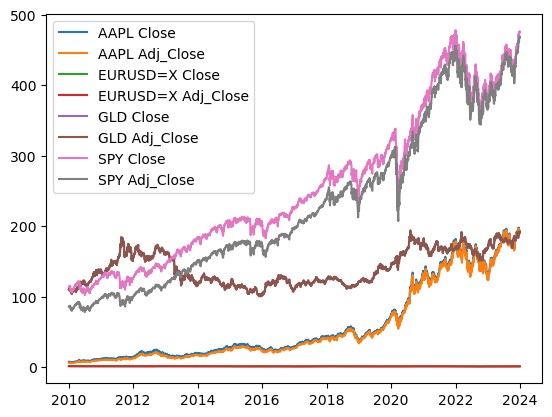

In [3]:
assets.dropna(inplace=True)
for ticker in assets["Close"].columns.get_level_values("Ticker").unique():
    plt.plot(assets["Close"][ticker],label=ticker+" Close")
    plt.plot(assets["Adj Close"][ticker],label=ticker+" Adj_Close")
plt.legend()

Instead of subtracting the total dividend value from the price, a multiplier is calculated based on the dividend and the most recent close price before the dividend was paid. This factor, which is always greater than 0 and less than 1, will be applied to all the prices until the next dividend going back in time. On the next dividend, a new factor is calculated.

The factor is always calculated as 1 - (dividend/price).

In [4]:
assets['Dividends'] = assets['Dividends'].replace(0,np.nan)

factor = 1 - (assets['Dividends'][~pd.isnull(assets['Dividends'])].fillna(0)/
              assets[~assets['Dividends'].shift(-1).isna()]['Close'].shift())

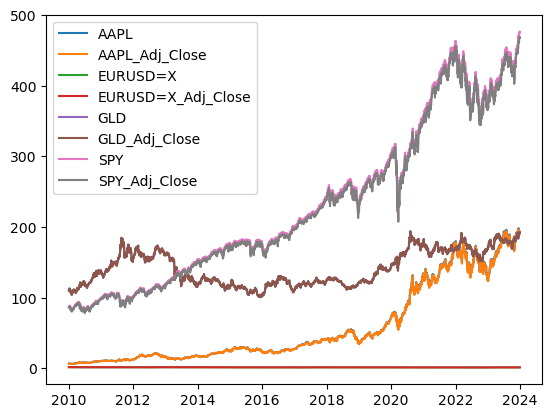

In [9]:
for ticker in assets["Close"].columns.get_level_values("Ticker").unique():
    new_factor = factor[ticker].dropna().sort_index(ascending=False).cumprod().sort_index().reindex(factor.index).bfill().fillna(1)
    plt.plot((new_factor)*(assets['Close'][ticker]),label=ticker)
    plt.plot((assets['Adj Close'][ticker]),label=f"{ticker}_Adj_Close")
plt.legend()
plt.show()

In [10]:
Close_to_Close_Returns = assets["Close"].pct_change()
Close_to_Close_Returns.columns = pd.MultiIndex.from_product([['Close_to_Close_Returns'],Close_to_Close_Returns.columns])

# Overnight Returns
Close_to_Open_Returns = (assets['Open'] / assets['Close'].shift() - 1)
Close_to_Open_Returns.columns = pd.MultiIndex.from_product([['Close_to_Open_Returns'],Close_to_Open_Returns.columns])

# Intraday Returns
Open_to_Close_Returns = (assets['Close'] / assets['Open'] - 1)
Open_to_Close_Returns.columns = pd.MultiIndex.from_product([['Open_to_Close_Returns'],Open_to_Close_Returns.columns])

Open_to_Open_Returns = assets['Open'].pct_change()
Open_to_Open_Returns.columns = pd.MultiIndex.from_product([['Open_to_Open_Returns'],Open_to_Open_Returns.columns])

# Use assign method to add all columns at once
new_assets = pd.concat([assets, Close_to_Close_Returns, Close_to_Open_Returns, Open_to_Close_Returns, Open_to_Open_Returns], axis=1)
new_assets.columns.names = ["Features", "Tickers"]

<Axes: xlabel='Date'>

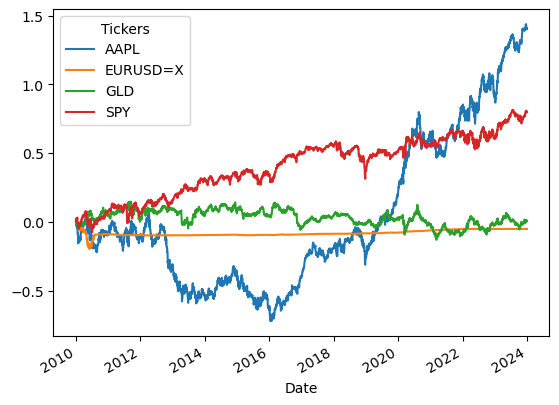

In [11]:
new_assets["Open_to_Close_Returns"].cumsum().plot()

<Axes: xlabel='Date'>

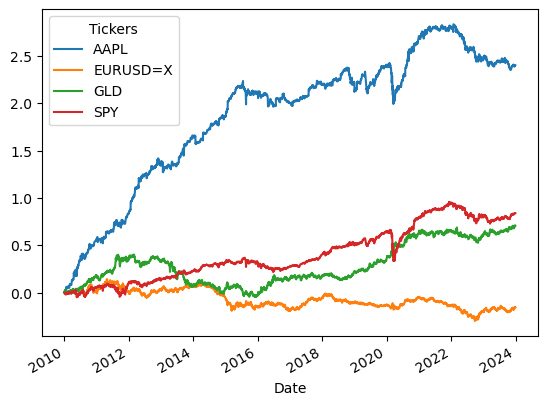

In [12]:
new_assets["Close_to_Open_Returns"].cumsum().plot()

<Axes: xlabel='Date'>

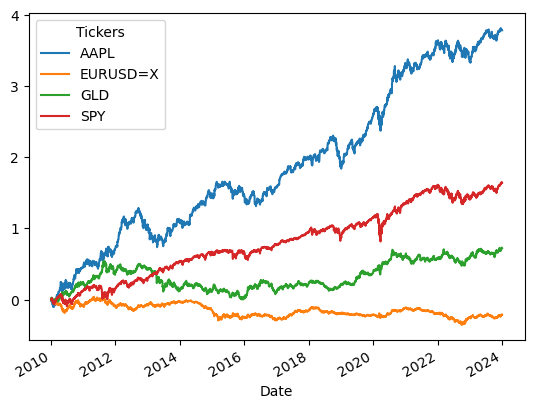

In [13]:
new_assets["Close_to_Close_Returns"].cumsum().plot()

<Axes: xlabel='Date'>

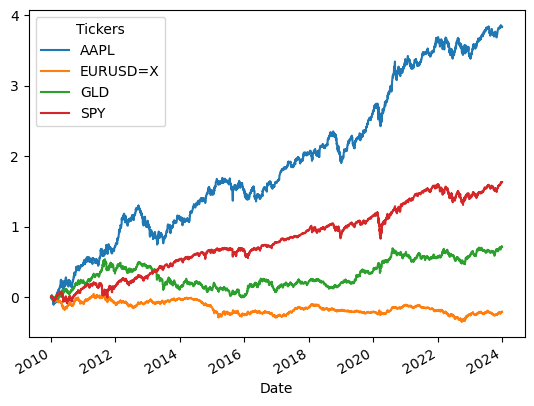

In [14]:
new_assets["Open_to_Open_Returns"].cumsum().plot()

<Axes: xlabel='Date'>

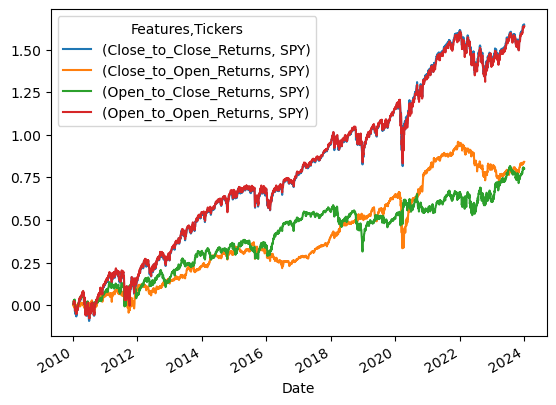

In [15]:
new_assets.xs("SPY",level="Tickers",axis=1,drop_level=False).iloc[:,-4:].cumsum().plot()

<Axes: xlabel='Date'>

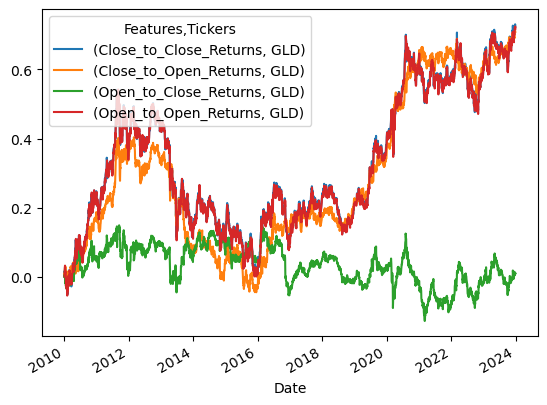

In [16]:
new_assets.xs("GLD",level="Tickers",axis=1,drop_level=False).iloc[:,-4:].cumsum().plot()

<Axes: xlabel='Date'>

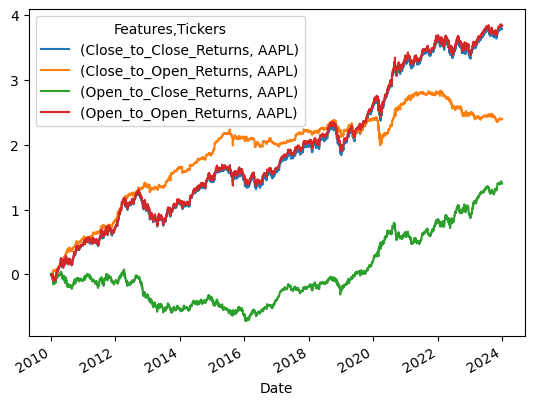

In [17]:
new_assets.xs("AAPL",level="Tickers",axis=1,drop_level=False).iloc[:,-4:].cumsum().plot()